# 95-865 Fall 2018 Final Exam

Your name: Ruixin Huang

Your Andrew ID: ruixinh

**Preamble**: You will need to install `joblib`, which can be done via the terminal command below:

```
conda install -c anaconda joblib
```

When loading `fashion_mystery.hd5` in Problem 2(c), if you run into an error saying `ValueError: Unknown layer:name`, please update your version of `keras` so that the file actually loads. A related post: https://stackoverflow.com/questions/53180589/keras-valueerror-unknown-layername-when-trying-to-load-model-to-another-platf?noredirect=1&lq=1

There are three problems on this exam. You can do these three problems in any order. Problem 1 is a short warmup problem *with no coding*. Problems 2 and 3 involve coding. We have prepared a bunch of imports for you in the next cell. Please execute this before you do problems 2 and 3.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sn
plt.style.use('ggplot')
# %config InlineBackend.figure_format = 'retina'  # if you use a Mac with Retina display

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import joblib

# these next three lines are meant to turn off GPU usage
# (for this final exam, you do not need a GPU)
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Using TensorFlow backend.


# Problem 1: Warm-Up [10 points]

(a) Answer if the given statement is true or false, and provide your reason: "Stochastic gradient descent is a special case of minibatch gradient descent."

**Your answer (no code)**: The statement is ture, I think the reason is In the stochastic gradient descent method, the parameters in the model are adjusted according to only one sample at a time, which is equivalent to the mini-batch gradient descent in the case of b=1 described above, that is, there is only one training sample in each mini-batch. So, this could be explained why "Stochastic gradient descent is a special case of minibatch gradient descent."

(b) Consider a length-3 sequence [x, y, z] (if you want, you can think of this as an image with 1 row and 3 columns, where the pixel's have values x, y, and z]). We feed this sequence as the input to a convolutional layer with two filters [a, b] and [c, d]. This convolutional layer does not do any padding. What is the output of this convolutional layer in terms of the variables x, y, z, a, b, c, d?

**Your answer (no code)**: the output concolutional layer one after using filter [a,b] is [x*a+x*b,y*a+y*b,z*a+z*b], the output convolutional layer two after using filter[c,d] is [x*c+x*d,y*c+y*d,z*c+z*d]

(c) Your manager wants you to build an algorithm to detect if news articles being featured on your website are fake or not. You train a probabilistic classifier such as logistic regression which treats fake articles as the positive class and real news articles as the negative class. You show your manager the accuracy, precision, and recall of your trained model. Your manager states that it would be great if the algorithm could be tuned so that the anti-abuse team at your company only has to investigate the news articles which are marked with the highest probability of being fake while not generating too many false positives which the team has to investigate needlessly. In this situation, will you use the precision-recall curve or the receiver operating characteristic (ROC) curve to decide the probability threshold above which news articles are marked as fake?

**Your answer (no code)**:  Yes, I would use PRC or ROC model, due to setting the real new articals as the negative class. In the real situation, the quantity of real articals always much more than fake articals, we hope we can check all of the fake news, even sacrify the accurancy. Besides, we also will hope we can check each new in the right situation, we don't want to serve real news become fake news. Because of this, we need to make sure the recall is low. Therefore, it is useful to use PRC and ROC model.

(d) Answer if the given statement is true or false, and provide your reason: "The cross-entropy loss is applicable only to binary classification. For number of classes beyond 2, we need to use more general losses such as KL divergence."

**Your answer (no code)**: This is false. because in term of any model trained by the gradient optimization method, minimizing the cross-entropy between the data distribution and the model distribution gives the same result as the minimized KL divergence. cross-entropy not only suit for binary, but also suit for mutiple

(e) Answer if the given statement is true or false, and provide your reason: "t-SNE dimensionality reduction algorithm models the distribution of distances in both the original and embedding space using Student's t-distribution."

**Your answer (no code)**: It is false. Because Studen's t-distribution in t-SNE is used to figure out the similarity in embedding space instead of distances.

# Problem 2: Dimensionality reduction and prediction [50 points]

One of the main concepts in 95-865 is that even though unstructured data often come from high-dimensional feature spaces, they actually usually exhibit some sort of low-dimensional structure. In the first half of the class, we looked at *unsupervised* dimensionality reduction. In this problem, we look at how combining unsupervised dimensionality reduction method (e.g., PCA, t-SNE) with a classifier compares with an "end-to-end" neural net approach that tries to learn everything at once. To answer this question, we focus on an image classification and examine four different approaches:

(a) No dimensionality reduction at all: use the raw features for classification.

(b) Reduce the dimensionality of the data using PCA, and *use the low-dimensional PCA representation* of the data for classification.

(c) The same thing as approach (b) except where we use Isomap instead of PCA.

(d) A simple neural net approach that automatically learns a low-dimensional representation while also making predictions.

For approaches (a), (b), and (c), we use logistic regression (generalized to multiple classes) as the classifier (so that the classifier used in all four approaches corresponds to logistic regression). Note that for approaches (a), (b), and (c), your code should not use `keras`.

**Data**: In exploring these approaches, we use the Fashion MNIST dataset, which you saw during the mid-mini quiz. As a reminder, this dataset is collected by Zalando Research and is similar to the popular MNIST dataset for handwritten digit recognition that we have seen throughout 95-865. Each image is 28-by-28 pixels and has a numerical label from 0, 1, ..., up to 9 (**0 → T-shirt/top, 1 → Trouser, 2 → Pullover, 3 → Dress, 4 → Coat, 5 →
Sandal, 6 → Shirt, 7 → Sneaker, 8 → Bag, 9 → Ankle boot**). Example images from the dataset are shown below.

![Example Images](fashion-mnist-sprite.png)

We have already curated training and test data for you. Please run the next cell before moving on to the subsequent parts. Note that each image has been flattened already.

In [2]:
X_train = np.loadtxt('fashion_X_train.txt')
y_train = np.loadtxt('fashion_y_train.txt')
X_test = np.loadtxt('fashion_X_test.txt')
y_test = np.loadtxt('fashion_y_test.txt')
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(9000, 784) (9000,)
(1000, 784) (1000,)


## Problem 2(a): Multiclass logistic regression without dimensionality reduction

Using the training data, train a classifier using scikit-learn's `LogisticRegression` class (from `sklearn.linear_model`). Please use the following parameters when creating your `LogisticRegression` object (do not set any of the other parameters):

- Set `multi_class` to `'multinomial'` (so that the classifer uses categorical cross entropy loss)
- Set `solver` to `'lbfgs'`
- Set `random_state` to 0
- Set `C` to 10000 (intentionally reduce the amount of regularization)

After training the classifier, compute and print the prediction accuracy (fraction of correct predictions) on the test data.

In [21]:
# ------------------------------------------------------------------------------
# TODO: WRITE YOUR CODE HERE
#
clf = LogisticRegression(random_state=0,solver='lbfgs',multi_class='multinomial',C=10000)
clf.fit(X_train,y_train)
clf.score(X_train,y_train)
#
# END OF YOUR CODE
# ------------------------------------------------------------------------------

0.8967777777777778

## Problem 2(b): PCA with multiclass logistic regression

### Problem 2(b)-Subpart (i)

Now we are going to try the following approach:

1. Reduce the dimensionality of the input data using PCA
2. Train a logistic regression classifier using the transformed (i.e., low-dimensional) representation of the input data as feature vectors (and using the original labels); for the logistic regression classifier, use the exact same algorithm parameters as for part (a), including `random_state=0`

Note that there is a single hyperparameter here: the number of dimensions to reduce to. Use 5-fold cross validation (using raw accuracy) to select this number of dimensions from integers 10, 20, 30, ..., 100. Importantly, at no point should your training procedure for doing the above two steps ever be looking at test data (`X_test` and `y_test`). **After doing the cross validation, plot the cross validation score vs PCA dimensionality and also be sure to store and print out what the best number of dimensions is.**

To be clear: how one trains a model for this proposed approach is to first fit a PCA model, use it to obtain the lower-dimensional representation, and then use the low dimensional representation to train a logistic regression classifier. When using the model to make predictions, you should *not* be doing any refitting!

In [31]:
# WARNING: YOU SHOULD ONLY HAVE TO WRITE CODE IN THE PART BELOW THAT SAYS "TODO"
kf = KFold(n_splits=5, random_state=0, shuffle=True)
best_cross_val_score = -np.inf
best_PCA_dim = None
low_dim_range = range(10, 101, 10)
cross_val_scores = []

for low_dim in low_dim_range:
    # --------------------------------------------------------------------------
    # TODO: WRITE YOUR CODE HERE
    #
    dimension_pca = PCA(n_components=low_dim)
    X_train_std = dimension_pca.fit_transform(X_train)
    ytrain_std = y_train.T
    cross_val_score = -1  # this value is obviously wrong and is for you to fill
                          # in with the correct 5-fold cross-validation score;
                          # remember to use the same algorithm parameters for
                          # logistic regression as in part (a), including
                          # setting `random_state=0`  
    for k, (train, val) in enumerate(kf.split(X_train, y_train)):
        clf = LogisticRegression(random_state=0)
        clf.fit(X_train_std[train], y_train)
        ypred = clf.predict(X_train_std[val])
        yval = y_train[val]
        cross_val_scor = clf.score(ypred,yval)
        
    #
    # END OF YOUR CODE
    # --------------------------------------------------------------------------
    
    cross_val_scores.append(cross_val_score)
    print('# PCA dim:', low_dim, 'cross val score:', cross_val_score)
    if cross_val_score > best_cross_val_score:
        best_cross_val_score = cross_val_score
        best_PCA_dim = low_dim

plt.plot(low_dim_range, cross_val_scores)
plt.xlabel('PCA dimensionality')
plt.ylabel('Cross validation score (raw accuracy)')

print('Best #PCA dim:', best_PCA_dim,
      'best cross val score:', best_cross_val_score)

ValueError: Found input variables with inconsistent numbers of samples: [7200, 9000]

### Problem 2(b)-Subpart (ii)

Using the best number of PCA dimensions found, train the model using all training data. What is the prediction accuracy (fraction of correct predictions) on the test data (print this accuracy)?

In [ ]:
# ------------------------------------------------------------------------------
# TODO: WRITE YOUR CODE HERE
#

#
# END OF YOUR CODE
# ------------------------------------------------------------------------------

## Problem 2(c): Isomap with multiclass logistic regression

We now repeat the analysis for problem 2(b) except using Isomap instead of PCA. Because the analysis using Isomap is extremely slow, we run most of the analysis for you ahead of time. In fact, here's the 5-fold cross-validation plot varying the Isomap dimensionality (sweeping over the same values as in problem 2(b)):

![Isomap cross validation](fashion_isomap_cross_val.png)

The best Isomap dimensionality found is 100, which achieves a cross validation score of 0.791.

Subpart (i) below asks how you would produce the above plot with code (we aren't asking you to actually compute it since it would take too long to run).

### Problem 2(c)-Subpart (i)

Clearly and concisely state how you would change your answer to problem 2(b) to use scikit-learn's [Isomap](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap) class instead of PCA (for Isomap, assume that you use all the default parameters except for `n_components`, which refers to the number of dimensions to reduce to). Your answer should include a code snippet in it, but the code snippet is *not* meant to be run (since it would be very slow to run during the exam!).

**Note**: While we did not use scikit-learn's Isomap class in any of the lectures/recitations, the Isomap class is used in an *extremely* similar way to scikit-learn's PCA class. To answer this problem, you do not actually need to use any knowledge of what happens under the hood for Isomap (for example, your answer should not include any code for multidimensional scaling).

**Your answer (there should be a code snippet in it)**: Because use PCA would decrease the accuracy in reduce dimensions.

```
YOUR CODE SNIPPET GOES HERE
```

### Problem 2(c)-Subpart (ii)

Using the full training dataset, we trained Isomap (using 100 dimensions) followed by multiclass logistic regression. The pre-trained Isomap model was ~1.5GB, so instead of giving you that, we have gone ahead and transformed the test feature vectors to 100-dimensional vectors using our pre-trained Isomap model. Using these lower-dimensional representations of the test data, along with the pre-trained multiclass logistic regression model, compute and print out the prediction accuracy (fraction of correct predictions) for the test data.

In [ ]:
# DO NOT MODIFY THESE FIRST TWO LINES
X_test_isomap = np.loadtxt('fashion_X_test_isomap.txt')
log_reg_after_isomap = joblib.load('fashion_mystery.joblib')

# ------------------------------------------------------------------------------
# TODO: WRITE YOUR CODE HERE
#

#
# END OF YOUR CODE
# ------------------------------------------------------------------------------

### Problem 2(c)-Subpart (iii)

Why wouldn't your answer to subpart (i) work if we had used t-SNE? Very briefly explain.

**Hint**: From a quick look at scikit-learn's documentation for both Isomap and t-SNE, you should be able to answer this question.

**Your answer here**: REPLACE THIS WITH YOUR ANSWER

## Problem 2(d): a neural net approach

We have run 5-fold cross-validation already using a CNN, where we only varied the size of a Dense layer right before the final multiclass logistic regression layer/classifier. We set the number of neurons to be 10, 20, ..., up to 100, just like with problems 2(b) and 2(c). We got the following plot:

![Fashion MNIST CNN 5-fold cross-validation](fashion_cnn_cross_val.png)

The best choice for the dimensionality of the space prior to the final logistic regression layer turned out to be 40. We then trained the CNN on all the training data using dimensionality 40 for the dense layer before the logistic regression. We saved the resulting model in `fashion_mystery.hd5`. We first load the model and print out its summary:

In [38]:
cnn_model = load_model('fashion_mystery.hd5')
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_125 (MaxPoolin (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 10, 10, 32)        18464     
_________________________________________________________________
max_pooling2d_126 (MaxPoolin (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_63 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_125 (Dense)            (None, 40)                32040     
_________________________________________________________________
dense_126 (Dense)            (None, 10)                410       
Total para

### Problem 2(d)-Subpart (i)

What are the sizes of the convolution filters used in the Conv2D layers? (Also, briefly explain how you determined this.)

**Your answer here (no code)**: I think we need to use small size of filter such as 3*3 or 5*5, because out dataset is not big, it can improve the efficiency

### Problem 2(d)-Subpart (ii)

What is the prediction accuracy (fraction of correct predictions) on the test set using the CNN?

*Hint*: To answer this question, you will need to remember to transform your test feature vectors and labels so that they are shaped the right way for the neural net to work with.

In [ ]:
# ------------------------------------------------------------------------------
# TODO: WRITE YOUR CODE HERE
#

#
# END OF YOUR CODE
# ------------------------------------------------------------------------------

### Problem 2(d)-Subpart (iii)

Compute the confusion matrix for the test data using the CNN. To do this, use scikit-learn's [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix) function. Note that the rows index the true labels, and the columns index the predicted labels. Also compute a normalized version of this table where each row is divided by the row sum in the original confusion matrix. We have already provided plotting code.

In [ ]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# ------------------------------------------------------------------------------
# TODO: WRITE YOUR CODE HERE
#
conf_mat = np.zeros((10, 10))  # fill this out correctly
normalized_conf_mat = np.zeros((10, 10))  # fill this out correctly
#
# END OF YOUR CODE
# ------------------------------------------------------------------------------

plt.figure(figsize=(10, 10))
sn.heatmap(conf_mat, annot=True,
           xticklabels=classes,
           yticklabels=classes)
plt.title('Confusion Matrix')

plt.figure(figsize=(10, 10))
sn.heatmap(normalized_conf_mat, annot=True,
           xticklabels=classes,
           yticklabels=classes)
plt.title('Normalized Confusion Matrix')

In the normalized confusion matrix, what do the different numbers represent?

**Your answer (no code)**: predict is in the column, actual is in the line, all the right prediction is on the diagonal

What can you say about two largest off-diagonal entries (please relate these back to what the labels represent, e.g., trousers, dresses, etc)?

**Your answer (no code)**: In general ,they are right prediction

What item type do you think is easiest (most accurate) for the CNN to classify?

**Your answer (no code)**: improve the Convolution layer

## Problem 2(e): Observations about approaches (a) through (d)

All four approaches we just examined in this problem involve using a multiclass logistic regression classifier. However, we changed the input given to this classifier.

What do you notice about the number of dimensions (in the low dimensional space) chosen for PCA and Isomap compared to that of the CNN?

**Your answer (no code)**: REPLACE THIS WITH YOUR ANSWER

What do you notice about the test set prediction accuracy of the PCA-based and Isomap-based approaches compared to the multiclass logistic regression classifier of part (a)?

**Your answer (no code)**: REPLACE THIS WITH YOUR ANSWER

Why do you think the test set accuracies turned out the way they did?

**Your answer (no code)**: REPLACE THIS WITH YOUR ANSWER

# Problem 3: Predicting Diabetes Cases [40 points]

The National Institute of Diabetes and Digestive and Kidney Diseases has collected the Pima Indians dataset, which contains data from clinical exams for women age 21 and above of Pima Indian origins. In this problem, we predict whether each woman has diabetes or not based on diagnostic measurements.

For each woman, the following features were recorded:
- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- Blood Pressure: Diastolic blood pressure (mm Hg)
- Skin Thickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- Diabetes Pedigree Function: Diabetes pedigree function
- Age: Age (years)

Per woman, the label is binary (1=diabetic, 0=not diabetic).

We begin by loading in the data:

In [27]:
diabetes_X_train = np.loadtxt('diabetes_X_train.txt')
diabetes_y_train = np.loadtxt('diabetes_y_train.txt')
diabetes_X_test = np.loadtxt('diabetes_X_test.txt')
diabetes_y_test = np.loadtxt('diabetes_y_test.txt')
diabetes_features = ['Pregnancies',
                     'Glucose',
                     'Blood Pressure',
                     'Skin Thickness',
                     'Insulin',
                     'BMI',
                     'Diabetes Pedigree Function',
                     'Age']
print(diabetes_X_train.shape, diabetes_y_train.shape)
print(diabetes_X_test.shape, diabetes_y_test.shape)

(576, 8) (576,)
(192, 8) (192,)


## Problem 3(a)

Explore the training data by drawing a histogram for each feature.

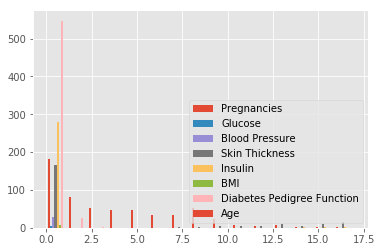

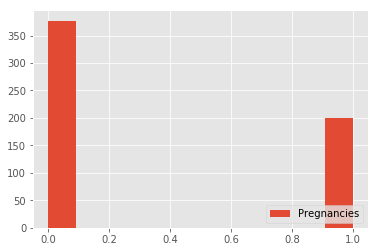

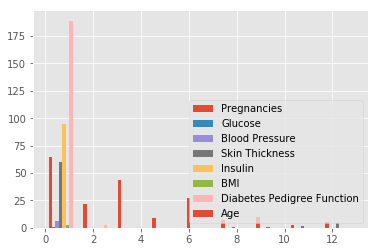

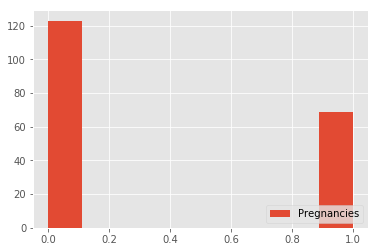

In [28]:
# ------------------------------------------------------------------------------
# TODO: WRITE YOUR CODE HERE
#
plt.hist(diabetes_X_train, label=diabetes_features,bins='auto')
plt.legend(loc="lower right")
plt.show()

plt.hist(diabetes_y_train, label=diabetes_features, bins='auto')
plt.legend(loc="lower right")
plt.show()

plt.hist(diabetes_X_test,label=diabetes_features, bins='auto')
plt.legend(loc="lower right")
plt.show()

plt.hist(diabetes_y_test, label=diabetes_features,bins='auto')
plt.legend(loc="lower right")
plt.show()

#
# END OF YOUR CODE
# ------------------------------------------------------------------------------

Clearly explain why the features should be standardized.

**Your answer (no code)**: the features is bias, in real world, if data is big, it should follow normal distribution

Suppose that we are standardizing the data (by subtracting off each feature's mean and dividing by its standard deviation) and also doing cross-validation. Explain why standardization should *not* be applied to the full training dataset first before running cross-validation. When should standardization be run?

**Your answer (no code)**: Remove one or more data locations, and then use data from other locations to predict the data associated with them. In this way, you can compare the predicted values with the measured values and get useful information. If the prediction error is unbiased, the average prediction error should be close to 0. However, this value depends on the size of the data; to standardize it, the standardized prediction error can be obtained by dividing the prediction error by its prediction standard error.

## Problem 3(b): Support Vector Classification

We now train a linear SVM (scikit-learn's `LinearSVC`) to classify whether a Pima Indian woman has diabetes or not. We use 5-fold cross-validation, making sure to account for the feature standardization in part (a).

### Problem 3(b)-Subpart (i)

Suppose that we sweep over hyperparameter `C` for SVM, using exactly 10 different possible values for `C` with 5-fold cross-validation. How many SVM classifiers will get trained during cross-validation, and (roughly) how many training data get used for each fold?

**Your answer (no code)**: REPLACE THIS WITH YOUR ANSWER

### Problem 3(b)-Subpart (ii)

We shall use 5-fold cross-validation but with a twist! For each fold, compute *two* different scores: the true positive rate and the false positive rate. In other words, after running 5-fold cross-validation, for each of the five hyperparameter choices for `C`, we will have two different numbers: average true positive rate across folds for that hyperparameter choice, and average false positive rate across folds for that hyperparameter choice.

Importantly, please use scikit-learn's `LinearSVC` classifier specifying only `C` and `random_state=95865`.

**Note**: For this variant of cross-validation, we are not yet selecting a best score yet (especially since there are two scores). This is why in the code provided below, there is no need to keep track of the best score seen so far, etc. However, we make sure to store all the cross-validation scores computed. Note that your code should *not* be using `decision_function`.

In [29]:
# WARNING: YOU SHOULD ONLY HAVE TO WRITE CODE IN THE PART BELOW THAT SAYS "TODO"
kf = KFold(n_splits=5, random_state=0, shuffle=True)
C_range = np.logspace(-4, 1, 10)  # 10 different choices
svm_cross_val_true_positive_rates = []
svm_cross_val_false_positive_rates = []

for C in C_range:
    # --------------------------------------------------------------------------
    # TODO: WRITE YOUR CODE HERE
    #
    cross_val_true_pos_rate = -1  # this value is obviously wrong and is for
                                  # you to fill in with the correct 5-fold
                                  # cross-validation score for true positive
                                  # rate
    cross_val_false_pos_rate = -1  # this value is obviously wrong and is for
                                   # you to fill in with the correct 5-fold
                                   # cross-validation score for false positive
                                   # rate
    for k, (train, val) in enumerate(kf.split(diabetes_X_train, diabetes_y_train)):
        clf = LinearSVC(random_state=95865)
        probas_ =clf.fit(diabetes_X_train[train], diabetes_y_train[train])
        ypred = clf.predict(diabetes_X_train[val])
        yval = diabetes_y_train[val]
    #
    # END OF YOUR CODE
    # --------------------------------------------------------------------------
    
    print('C: %8.4f' % C,
          'TPR: %6.4f' % cross_val_true_pos_rate,
          'FPR: %6.4f' % cross_val_false_pos_rate)
    svm_cross_val_true_positive_rates.append(cross_val_true_pos_rate)
    svm_cross_val_false_positive_rates.append(cross_val_false_pos_rate)

C:   0.0001 TPR: -1.0000 FPR: -1.0000
C:   0.0004 TPR: -1.0000 FPR: -1.0000
C:   0.0013 TPR: -1.0000 FPR: -1.0000
C:   0.0046 TPR: -1.0000 FPR: -1.0000
C:   0.0167 TPR: -1.0000 FPR: -1.0000
C:   0.0599 TPR: -1.0000 FPR: -1.0000
C:   0.2154 TPR: -1.0000 FPR: -1.0000
C:   0.7743 TPR: -1.0000 FPR: -1.0000
C:   2.7826 TPR: -1.0000 FPR: -1.0000
C:  10.0000 TPR: -1.0000 FPR: -1.0000


### Problem 3(b)-Subpart (iii)

Plot the true positive rate vs false positive rate. (The x-axis should be FPR and the y-axis should be TPR.)

In [36]:
# ------------------------------------------------------------------------------
# TODO: WRITE YOUR CODE HERE
#

fpr, tpr, thresholds = roc_curve(True, 1, pos_label=1)
auc = np.trapz(cross_val_true_pos_rate, cross_val_false_pos_rate)
plt.plot(cross_val_true_pos_rate, cross_val_false_pos_rate, linestyle='-', alpha=0.5, color='C0',label='SVM' % auc)


plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="lower right")
plt.grid()
plt.show()
#
# END OF YOUR CODE
# ------------------------------------------------------------------------------

ValueError: Expected array-like (array or non-string sequence), got True

### Problem 3(b)-Subpart (iv)

Using the plot above, suppose that for our clinical application, we can have at most a false positive rate of 12%. Under this constraint, what is the largest true positive rate that we could approximately be able to achieve according to our cross validation results? Which value of hyperparameter `C` (among the ones we tried in cross validation) does this roughly correspond to?

**Your answer**: REPLACE THIS WITH YOUR ANSWER

**Important observation**: Your answer to the above question should make it clear that using training data and an ROC curve, we can actually pick a hyperparameter based on some application-specific constraint. The hyperparameter chosen can then be used for test data!

## Problem 3(c): Random Forest Classification

Repeat problem 3(b) except now using a random forest classifier, sweeping over 4 different `n_estimators` values (50, 100, 150, 200) and 6 `max_depth` values (2, 3, 4, 5, 6, 7), i.e., sweep over a total of 4x6=24 hyperparameter settings. For the `RandomForestClassifier`, aside from `n_estimators` and `max_depth`, only specify one additional setting `random_state=95865`. When you generate your cross-validation-based ROC plot, use a scatter plot (`plt.scatter`) instead of a line plot.

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

vectorizer = CountVectorizer(min_df=50, max_df=0.8,max_features=1000,stop_words="english")
#X_train=pd.Series(diabetes_X_train.reshape(4608, 1))
X = vectorizer.fit_transform(diabetes_X_train)
voca=vectorizer.get_feature_names()
#print(voca)
leng=[]
for i in voca:
    leng.append(i)
print(len(leng))

flattened_X = X.reshape(len(leng), -1).astype(np.float32).todense()
num_X = len(flattened_X)
indices = range(num_X )


kf = KFold(n_splits=5, random_state=0, shuffle=True)
num_trees_range = [50, 100, 150, 200]
max_depth_range = [2, 3, 4, 5, 6, 7]
hyperparam_range = [(num_trees, max_depth)
                    for num_trees in num_trees_range
                    for max_depth in max_depth_range]
rf_cross_val_true_positive_rates = []
rf_cross_val_false_positive_rates = []

for num_trees, max_depth in hyperparam_range:
    # --------------------------------------------------------------------------
    # TODO: WRITE YOUR CODE HERE
    #
    cross_val_true_pos_rate = -1  # this value is obviously wrong and is for
                                  # you to fill in with the correct 5-fold
                                  # cross-validation score for true positive
                                  # rate
    cross_val_false_pos_rate = -1  # this value is obviously wrong and is for
                                   # you to fill in with the correct 5-fold
                                   # cross-validation score for false positive
      
    # rate
    for train_indices, val_indices in kf.split(indices):
        rf_classifier = RandomForestClassifier(n_estimators=num_trees, max_depth=max_depth, random_state=95865)  # n_estimators is the number of trees
        rf_classifier.fit(flattened_X[train_indices],
                       Y_train[train_indices])
        rf_predicted_train_labels = rf_classifier.predict(flattened_X[val_indices])
        
    #
    # END OF YOUR CODE
    # --------------------------------------------------------------------------
    
    print('num_trees: %d' % num_trees,
          'max_depth: %d' % max_depth,
          'TPR: %6.4f' % cross_val_true_pos_rate,
          'FPR: %6.4f' % cross_val_false_pos_rate)
    rf_cross_val_true_positive_rates.append(cross_val_true_pos_rate)
    rf_cross_val_false_positive_rates.append(cross_val_false_pos_rate)

    
# ------------------------------------------------------------------------------
# TODO: WRITE YOUR PLOTTING CODE HERE
#

#
# END OF YOUR CODE
# ------------------------------------------------------------------------------

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

Under the same constraint as in part (b), namely that we want a false positive rate of no greater than 12%, what is the best achievable true positive rate for random forests at least according to the cross-validation results? What hyperparameter setting achieves this? Is this TPR higher than what was possible with a linear SVM classifier?

**Your answer (no code)**: REPLACE THIS WITH YOUR ANSWER

## Problem 3(d): How good is cross-validation in this case anyways?

For this part, we focus on using the linear SVM classifier, and we examine how good cross-validation from part (b) is in identifying which hyperparameters are good.

### Problem 3(d)-Subpart (i)

We start with a basic task: using the best hyperparameter `C` found in part (b), train a linear SVM using the full training dataset. Using this classifier, compute and print out its test set true positive rate and false positive rate.

In [ ]:
# ------------------------------------------------------------------------------
# TODO: WRITE YOUR CODE HERE
#

#
# END OF YOUR CODE
# ------------------------------------------------------------------------------

### Problem 3(d)-Subpart (ii)

Your code from subpart (i) uses the best choice of hyperparameter `C` from part (b) and computes a test set TPR and a test set FPR. However, you can actually repeat this calculation for each `C` within the range of values from part (b). By doing so, we again get a sequence of TPR's and FPR's from which we can plot an ROC curve! Put another way, instead of plotting an ROC curve using cross-validation, we can plot an ROC curve using simple data splitting, where the training dataset is the actual full training dataset, and the validation data is the actual test set. Plot the resulting ROC curve in this case, and overlay your training cross-validation ROC from earlier.

**Disclaimer**: At this point, we are definitely looking at the test data, so this analysis is meant for better understanding what we did right or wrong during the training phase in which we didn't peek at the test data.

In [ ]:
# DO NOT MODIFY THE NEXT TWO LINES; THESE ARE FOR YOU TO FILL OUT AND PLOT
svm_test_true_positive_rates = []
svm_test_false_positive_rates = []

# ------------------------------------------------------------------------------
# TODO: WRITE YOUR CODE HERE
#

#
# END OF YOUR CODE
# ------------------------------------------------------------------------------

Did your SVM cross-validation ROC curve from part (b) accurately estimate the true ROC curve?

**Your answer**: NO